In [1]:
import numpy as np
from matplotlib import pyplot as plt
import camb
from mcmc import planck_likelihood as pl
from tqdm import tqdm
import corner

1) Let's compute the power spectra for both parameter sets and check $\chi^2.$

chisq is  15267.937968222595  for  2501  degrees of freedom.


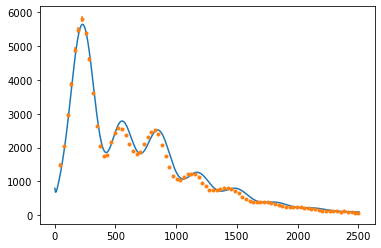

In [2]:
pars=np.asarray([60,0.02,0.1,0.05,2.00e-9,1.0])

pl.plot_spectrum(pars)

These parameters are not an acceptable fit. $\chi^2$ is much larger than the number of degrees of freedom.

chisq is  3272.2033778089576  for  2501  degrees of freedom.


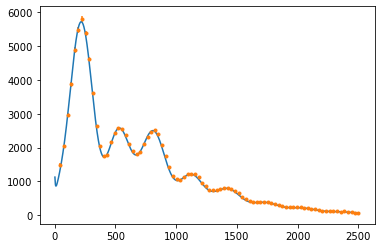

In [3]:
pars_new=np.asarray([69, 0.022, 0.12, 0.06, 2.1e-9, 0.95])

pl.plot_spectrum(pars_new)

These parameters are an acceptable fit. $\chi^2$ is more comparable to the degrees of freedom.

2) Let's first write our numerical differentiator. We will not be messing around with trying to find optimal dx here. This is sub-optimal, but will save a ton of time.

In [4]:
planck=np.loadtxt('mcmc/COM_PowerSpect_CMB-TT-full_R3.01.txt',skiprows=1)
ell=planck[:,0]
spec=planck[:,1]
errs=0.5*(planck[:,2]+planck[:,3])

def ndiff(func,m,x,y,frac=1e-5):
    derivs=np.empty([len(x),len(m)]) #partial derivative matrix
    for i in range(len(m)):
        dm=np.zeros(len(m))
        dm[i]=m[i]*frac #dm estimate, small fraction of ith parameter
        df=(func(m+dm)-func(m-dm))/(2*np.sum(dm))
        derivs[:,i]=df[:len(y)] #make derivatives same shape as data
    return derivs

We will now use Jon's Levenberg-Marquartd code but using the above numerical differentiator and additionally returning the covariance matrix.

In [8]:
def update_lamda(lamda,success):
    if success:
        lamda=lamda/1.5
        if lamda<0.5:
            lamda=0
    else:
        if lamda==0:
            lamda=1
        else:
            lamda=lamda*1.5**2
    return lamda

def get_matrices(m,fun,x,y,Ninv=None):
    model=fun(m)
    derivs=ndiff(fun,m,x,y) #use numerical differentiator
    model=model[:len(y)]
    r=y-model
    if Ninv is None:
        lhs=derivs.T@derivs
        rhs=derivs.T@r
        chisq=np.sum(r**2)
    else:
        lhs=derivs.T@Ninv@derivs
        rhs=derivs.T@(Ninv@r)
        chisq=r.T@Ninv@r
    return chisq,lhs,rhs,derivs

def linv(mat,lamda):
    mat=mat+lamda*np.diag(np.diag(mat))
    return np.linalg.inv(mat)

def fit_lm(m,fun,x,y,Ninv,niter=10,chitol=0.01):
    lamda=0
    chisq,lhs,rhs,derivs=get_matrices(m,fun,x,y,Ninv)
    for i in range(niter):
        lhs_inv=linv(lhs,lamda)
        dm=lhs_inv@rhs
        chisq_new,lhs_new,rhs_new,derivs_new=get_matrices(m+dm,fun,x,y,Ninv)
        if chisq_new<chisq:  
            if lamda==0:
                if (np.abs(chisq-chisq_new)<chitol):
                    print(np.abs(chisq-chisq_new))
                    print('Converged after ',i,' iterations of LM')
                    cov=np.linalg.inv(lhs_new) #covariance
                    return m+dm,cov
            chisq=chisq_new
            lhs=lhs_new
            rhs=rhs_new
            m=m+dm
            lamda=update_lamda(lamda,True)
        else:
            lamda=update_lamda(lamda,False)
        print('on iteration ',i,' chisq is ',chisq,' with step ',dm,' and lamda ',lamda)
    cov=np.linalg.inv(lhs_new) #covariance
    return m,cov

In [9]:
Ninv=np.diag(errs**(-2))
m,cov=fit_lm(pars_new,pl.get_spectrum,ell,spec,Ninv)

on iteration  0  chisq is  2588.8205666043855  with step  [-5.91797514e-01  3.78388472e-04 -2.78707577e-03  5.08667167e-02
  2.20186545e-10  2.47082107e-02]  and lamda  0
on iteration  1  chisq is  2577.5648234342634  with step  [-3.34711984e-01 -3.45476570e-05  8.29039639e-04 -3.17358238e-02
 -1.29896645e-10 -2.67622891e-03]  and lamda  0
on iteration  2  chisq is  2576.165712119754  with step  [ 2.04623166e-01  2.50124358e-05 -4.53518095e-04  7.75948908e-03
  3.47861729e-11  1.19486783e-03]  and lamda  0
on iteration  3  chisq is  2576.15426129455  with step  [-8.66334260e-02 -1.08586354e-05  1.94756997e-04 -2.94468024e-03
 -1.17057462e-11 -4.47472623e-04]  and lamda  0
0.0016770489228292718
Converged after  4  iterations of LM


It appears that our dx estimates worked since we managed to get $\chi^2$ pretty close to the number of degrees of freedom after only a handful of iterations. Let's save the best fit params and errors.

In [10]:
m_err=np.sqrt(np.diag(cov))
m_arr=np.asarray([m,m_err])

np.savetxt('planck_fit_params.txt',m_arr)

print('The best fit params are',m)
print('The corresponding errors are',m_err)

The best fit params are [6.82469208e+01 2.23644337e-02 1.17657399e-01 8.54343212e-02
 2.21927359e-09 9.73071475e-01]
The corresponding errors are [1.19768820e+00 2.22901848e-04 2.66624352e-03 3.53191844e-02
 1.48560579e-10 6.59642582e-03]


3) We will now estimate the parameters with an MCMC sampler. We will use Jon's function but sample from the covariance matrix which we just computed.

In [340]:
def run_chain(fun,pars,data=spec,errs=errs,cov=cov,nstep=10000,T=1.0):
    npar=len(pars)
    chain=np.zeros([nstep,npar])
    chisq=fun(pars,data,errs)
    chivec=np.zeros(nstep)
    for i in tqdm(range(nstep)):
        pars_trial=positive_step(pars,cov)
        chisq_trial=fun(pars_trial,data,errs)
        dchi=(chisq_trial-chisq)/T
        if np.random.rand(1)<np.exp(-0.5*dchi):
            pars=pars_trial
            chisq=chisq_trial
        chain[i,:]=pars
        chivec[i]=chisq
    return chain,chivec

def positive_step(pars,cov): #ensures that we aren't taking a step into negative parameter space
    pars_trial=pars+np.random.multivariate_normal(np.zeros(len(pars)),cov) #sample from covariance matrix
    if min(pars_trial)<0:
        pars_trial=positive_step(pars,cov)
    if min(pars_trial)>=0:
        return pars_trial

def power_chisq(pars,data,errs): #returns chi2 of power spectrum for given pars
    pred=pl.get_spectrum(pars)[:len(data)]
    return np.sum((pred-data)**2/errs**2)

In [341]:
pars0=positive_step(pars_new,cov) #perturb starting params
chain,chivec=run_chain(power_chisq,pars0) #run MCMC

  0%|                                     | 28/10000 [02:11<13:47:52,  4.98s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


  1%|▎                                    | 79/10000 [06:18<13:25:35,  4.87s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


  2%|▋                                   | 190/10000 [15:00<12:41:00,  4.65s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


  7%|██▎                                 | 653/10000 [51:02<12:02:05,  4.64s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


  7%|██▍                                 | 692/10000 [54:04<12:01:20,  4.65s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 15%|████▊                            | 1463/10000 [1:54:01<10:59:05,  4.63s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 16%|█████▎                           | 1617/10000 [2:05:57<10:45:52,  4.62s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▋                          | 2262/10000 [2:56:02<9:59:32,  4.65s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▋                          | 2271/10000 [2:56:43<9:50:01,  4.58s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▌                         | 2277/10000 [2:57:11<10:00:57,  4.67s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▌                         | 2279/10000 [2:57:20<10:03:06,  4.69s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▌                         | 2288/10000 [2:58:02<10:02:18,  4.69s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▊                          | 2315/10000 [3:00:07<9:51:39,  4.62s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▊                          | 2316/10000 [3:00:12<9:51:53,  4.62s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▉                          | 2349/10000 [3:02:48<9:51:50,  4.64s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 24%|███████▉                          | 2350/10000 [3:02:52<9:52:24,  4.65s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 24%|████████▎                         | 2431/10000 [3:09:09<9:47:22,  4.66s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 25%|████████▍                         | 2467/10000 [3:11:56<9:42:09,  4.64s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 26%|████████▋                         | 2562/10000 [3:19:19<9:50:04,  4.76s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 28%|█████████▍                        | 2789/10000 [3:37:00<9:22:56,  4.68s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 35%|███████████▊                      | 3464/10000 [4:29:29<8:26:44,  4.65s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 37%|████████████▌                     | 3688/10000 [4:46:51<8:10:21,  4.66s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 39%|█████████████▎                    | 3930/10000 [5:05:39<7:50:23,  4.65s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 41%|█████████████▉                    | 4092/10000 [5:18:11<7:36:40,  4.64s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 44%|██████████████▉                   | 4400/10000 [5:42:01<7:11:49,  4.63s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 54%|██████████████████▍               | 5432/10000 [7:02:13<5:59:59,  4.73s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 56%|██████████████████▉               | 5585/10000 [7:14:08<5:42:38,  4.66s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 59%|███████████████████▉              | 5851/10000 [7:34:55<5:25:13,  4.70s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 59%|███████████████████▉              | 5869/10000 [7:36:20<5:24:14,  4.71s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 63%|█████████████████████▍            | 6294/10000 [8:09:52<6:11:34,  6.02s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 63%|█████████████████████▍            | 6307/10000 [8:10:57<4:54:47,  4.79s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 64%|█████████████████████▋            | 6389/10000 [8:17:24<4:46:57,  4.77s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 67%|██████████████████████▊           | 6711/10000 [8:46:03<5:05:33,  5.57s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 71%|████████████████████████▎         | 7148/10000 [9:28:26<5:03:06,  6.38s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 74%|█████████████████████████▏        | 7404/10000 [9:54:33<4:10:50,  5.80s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 76%|████████████████████████▉        | 7575/10000 [10:11:53<4:30:56,  6.70s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 76%|█████████████████████████        | 7587/10000 [10:13:07<4:05:57,  6.12s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 76%|█████████████████████████        | 7589/10000 [10:13:20<4:02:52,  6.04s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 77%|█████████████████████████▍       | 7708/10000 [10:24:33<3:09:23,  4.96s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 84%|███████████████████████████▋     | 8406/10000 [11:33:00<2:13:15,  5.02s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 85%|████████████████████████████     | 8507/10000 [11:43:34<2:27:44,  5.94s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 90%|█████████████████████████████▋   | 8992/10000 [12:28:41<1:48:39,  6.47s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 90%|█████████████████████████████▋   | 9001/10000 [12:29:36<1:39:14,  5.96s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 91%|█████████████████████████████▉   | 9067/10000 [12:36:36<1:26:35,  5.57s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 96%|█████████████████████████████████▌ | 9576/10000 [13:26:33<35:52,  5.08s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 98%|██████████████████████████████████▍| 9834/10000 [13:51:36<15:55,  5.75s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


100%|██████████████████████████████████▊| 9963/10000 [14:04:37<03:41,  6.00s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


100%|██████████████████████████████████| 10000/10000 [14:08:23<00:00,  5.09s/it]


Let's take a look at the chain.

In [342]:
#save chivec and chain
np.savetxt('planck_chain.txt',np.concatenate((chivec.reshape(-1,1),chain),axis=1))

In [343]:
m_mc=np.mean(chain,axis=0)
m_err_mc=np.std(chain,axis=0)

print('The best fit params are',m_mc)
print('The corresponding errors are',m_err_mc)

The best fit params are [6.81935291e+01 2.23560274e-02 1.17825487e-01 8.27236236e-02
 2.21065908e-09 9.72723686e-01]
The corresponding errors are [1.14944624e+00 2.49985783e-04 2.59782071e-03 2.62549087e-02
 1.10234673e-10 6.97795096e-03]


All of the parameter means and errors are roughly comparable to the Levenberg-Marqartd method. We can also take a look at the corner plot.

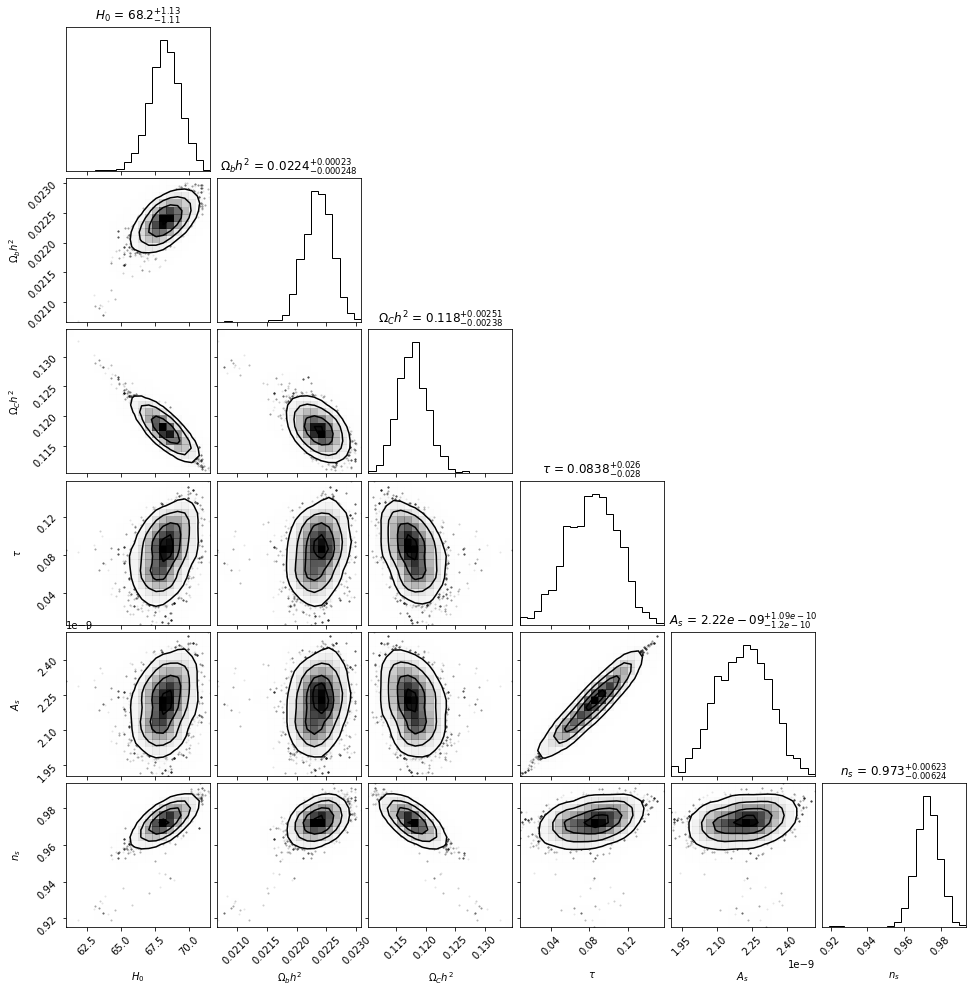

In [344]:
figure = corner.corner(chain, labels=[r'$H_0$',r'$\Omega_bh^2$',r'$\Omega_Ch^2$',r'$\tau$',r'$A_s$',r'$n_s$'],
                       smooth=True,title_fmt = '.3g',
                       show_titles=True, title_kwargs={"fontsize": 12})

#ignore the error bars on the parameters, they are not the standard deviation of the chain

The  corner plot looks reasonable. $\tau$ and $A_s$ have some degeneracy. We can look at the power spectra of the chains to check convergence.

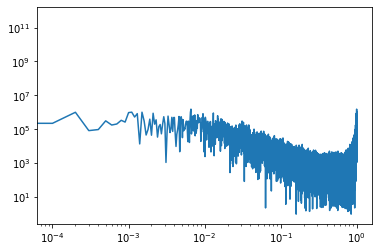

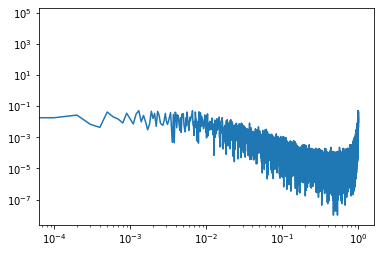

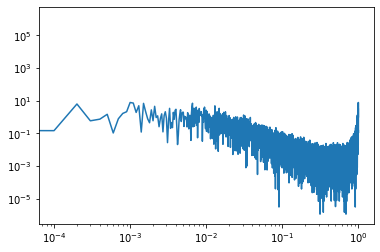

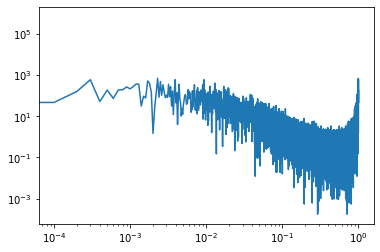

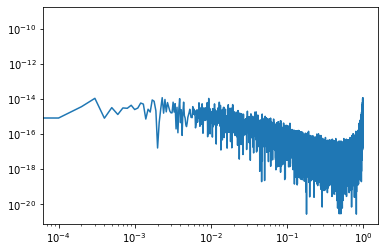

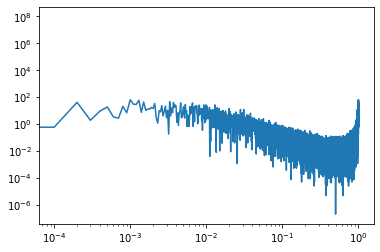

In [363]:
for i in range(len(chain.T)):
    plt.loglog(np.linspace(0,1,len(chain.T[i])),np.abs(np.fft.fft(chain.T[i]))**2)
    plt.show()

It looks like the knees are somewhere around $k\approx0.02.$ The chain is 10,000 samples long, so we have $\sim200$ independent samples. We should have good estimates for $1\sigma$ error bars.

4) We will now run the MCMC again with the $\tau$ prior. Before we do that, let's importance sample the chain. 

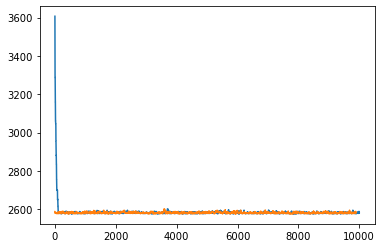

In [368]:
plt.plot(chivec)
plt.plot(chivec[110:])
plt.show()

We should probably burn the first 110 $\chi^2$ samples and then importance sampling.

In [369]:
mean_tau=0.054
err_tau=0.0074
burn=110
L_old=np.random.normal(chivec[burn:]) #chi2 likelihood
L_tau=np.exp(-0.5*(chain.T[3][burn:]-mean_tau)**2/err_tau**2) #tau likelihood
L_new=L_old*L_tau #combine the two

weights=L_new/np.sum(L_new) #get chain weights

m_tau=np.sum(weights*chain[burn:].T,axis=1) #importance sampled param means
m_err_tau=np.sqrt(np.sum(weights*((chain[burn:]-m_tau)**2).T,axis=1)) #importance sampled param errors

print('The importance sampled best fit params are',m_tau)
print('The corresponding errors are',m_err_tau)
print('Tau mean went from',m_mc[3],'to',m_tau[3])
print('Tau error bars went from',m_err_mc[3],'to',m_err_tau[3])

The importance sampled best fit params are [6.77768690e+01 2.22971390e-02 1.18707125e-01 5.58560629e-02
 2.09761197e-09 9.70631356e-01]
The corresponding errors are [9.56315180e-01 2.05769431e-04 2.18365355e-03 6.71662903e-03
 3.00334599e-11 5.43124458e-03]
Tau mean went from 0.08272362361453658 to 0.05585606290280253
Tau error bars went from 0.02625490868430946 to 0.006716629029107976


We observe that $\tau$ has shifted significantly towards the value inferred from polarization data and that the error bars have shrank by an order of magnitude. The other parameters did not shift nearly as much and their error bars haven't changed much either. We will now run a new MCMC, adding the $\tau$ prior.

In [393]:
def mod_power_chisq(pars,data,errs):
    mean_tau=0.054
    err_tau=0.0074
    chi1=power_chisq(pars,data,errs) #old chi2
    chi2=(pars[3]-mean_tau)**2/err_tau**2 #tau prior
    return chi1+chi2

cov_new=np.cov(chain[burn:].T) #recompute covariance matrix from chain
pars0=positive_step(m_tau,cov_new) #start somewhere near importance sampled means
chain_tau,chivec_tau=run_chain(mod_power_chisq,pars0,cov=cov_new) #run mcmc with tau prior

  1%|▏                                    | 61/10000 [06:01<14:18:25,  5.18s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


  1%|▍                                   | 108/10000 [10:01<14:01:16,  5.10s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


  4%|█▎                                  | 357/10000 [32:48<14:53:22,  5.56s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 10%|███▎                              | 989/10000 [1:33:01<16:45:34,  6.70s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 12%|███▊                             | 1155/10000 [1:49:10<14:00:03,  5.70s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 13%|████▍                            | 1346/10000 [2:09:36<16:50:22,  7.01s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 23%|███████▍                         | 2251/10000 [3:36:09<13:38:34,  6.34s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 27%|████████▉                        | 2727/10000 [4:17:18<12:48:45,  6.34s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 28%|█████████                        | 2765/10000 [4:21:12<10:20:32,  5.15s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 30%|██████████                        | 2956/10000 [4:36:59<8:20:58,  4.27s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 30%|██████████                        | 2961/10000 [4:37:20<8:20:09,  4.26s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 33%|███████████▎                      | 3328/10000 [5:05:47<8:48:15,  4.75s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 35%|███████████▉                      | 3499/10000 [5:18:22<7:45:44,  4.30s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 36%|████████████▏                     | 3576/10000 [5:23:51<7:36:47,  4.27s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 36%|████████████▏                     | 3585/10000 [5:24:30<7:37:21,  4.28s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 37%|████████████▍                     | 3674/10000 [5:30:53<7:27:02,  4.24s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 41%|██████████████                    | 4119/10000 [6:02:33<6:58:37,  4.27s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 41%|██████████████                    | 4120/10000 [6:02:38<6:58:40,  4.27s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 43%|██████████████▍                   | 4254/10000 [6:12:12<6:50:17,  4.28s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 43%|██████████████▌                   | 4265/10000 [6:12:59<6:48:06,  4.27s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 45%|███████████████▍                  | 4525/10000 [6:31:30<6:22:01,  4.19s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 53%|█████████████████▉                | 5266/10000 [7:24:15<5:34:33,  4.24s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 54%|██████████████████▎               | 5394/10000 [7:33:20<5:25:39,  4.24s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 55%|██████████████████▋               | 5478/10000 [7:39:16<5:18:17,  4.22s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 56%|██████████████████▉               | 5572/10000 [7:45:53<5:10:41,  4.21s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 57%|███████████████████▍              | 5704/10000 [7:55:14<5:10:17,  4.33s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 57%|███████████████████▍              | 5732/10000 [7:57:12<4:54:42,  4.14s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 59%|████████████████████              | 5917/10000 [8:10:18<4:45:56,  4.20s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 61%|████████████████████▋             | 6078/10000 [8:21:39<4:36:47,  4.23s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 62%|█████████████████████▏            | 6228/10000 [8:32:10<4:23:13,  4.19s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 63%|█████████████████████▍            | 6309/10000 [8:37:50<4:17:18,  4.18s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 63%|█████████████████████▍            | 6322/10000 [8:38:44<4:16:41,  4.19s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 65%|██████████████████████▏           | 6535/10000 [8:53:35<4:01:39,  4.18s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 66%|██████████████████████▎           | 6556/10000 [8:55:03<4:01:48,  4.21s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 66%|██████████████████████▍           | 6595/10000 [8:57:47<3:59:26,  4.22s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 67%|██████████████████████▉           | 6736/10000 [9:07:36<3:46:03,  4.16s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 74%|█████████████████████████         | 7385/10000 [9:53:31<3:01:45,  4.17s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 82%|███████████████████████████▏     | 8223/10000 [10:51:43<2:02:40,  4.14s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 82%|███████████████████████████▏     | 8231/10000 [10:52:17<2:02:08,  4.14s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 84%|███████████████████████████▊     | 8430/10000 [11:06:05<1:49:20,  4.18s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 87%|████████████████████████████▋    | 8696/10000 [11:24:29<1:29:46,  4.13s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 89%|█████████████████████████████▎   | 8868/10000 [11:36:22<1:17:36,  4.11s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 89%|█████████████████████████████▎   | 8888/10000 [11:37:46<1:17:43,  4.19s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 91%|██████████████████████████████   | 9100/10000 [11:52:24<1:01:53,  4.13s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 94%|████████████████████████████████▉  | 9414/10000 [12:14:09<40:36,  4.16s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 95%|█████████████████████████████████  | 9463/10000 [12:17:32<37:14,  4.16s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 95%|█████████████████████████████████▏ | 9495/10000 [12:19:45<34:48,  4.14s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 95%|█████████████████████████████████▎ | 9514/10000 [12:21:04<33:28,  4.13s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 96%|█████████████████████████████████▊ | 9650/10000 [12:30:28<24:19,  4.17s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 98%|██████████████████████████████████▏| 9761/10000 [12:38:08<16:41,  4.19s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 98%|██████████████████████████████████▏| 9781/10000 [12:39:30<15:06,  4.14s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


 99%|██████████████████████████████████▋| 9914/10000 [12:48:40<05:46,  4.02s/it]

 Check input parameters an Reionization_xe
 function in the Reionization module
 Check input parameters an Reionization_xe
 function in the Reionization module


100%|██████████████████████████████████| 10000/10000 [12:54:36<00:00,  4.65s/it]


In [394]:
m_tau_mc=np.mean(chain_tau,axis=0)
m_err_tau_mc=np.std(chain_tau,axis=0)

#save chivec and chain
np.savetxt('planck_chain_tauprior.txt',np.concatenate((chivec_tau.reshape(-1,1),chain_tau),axis=1))

print('The best fit params are',m_tau_mc)
print('The corresponding errors are',m_err_tau_mc)

The best fit params are [6.78552897e+01 2.22777919e-02 1.18449515e-01 5.60477092e-02
 2.09748177e-09 9.71007880e-01]
The corresponding errors are [1.02736125e+00 2.11802188e-04 2.30988032e-03 7.26792124e-03
 3.20459847e-11 5.34556091e-03]


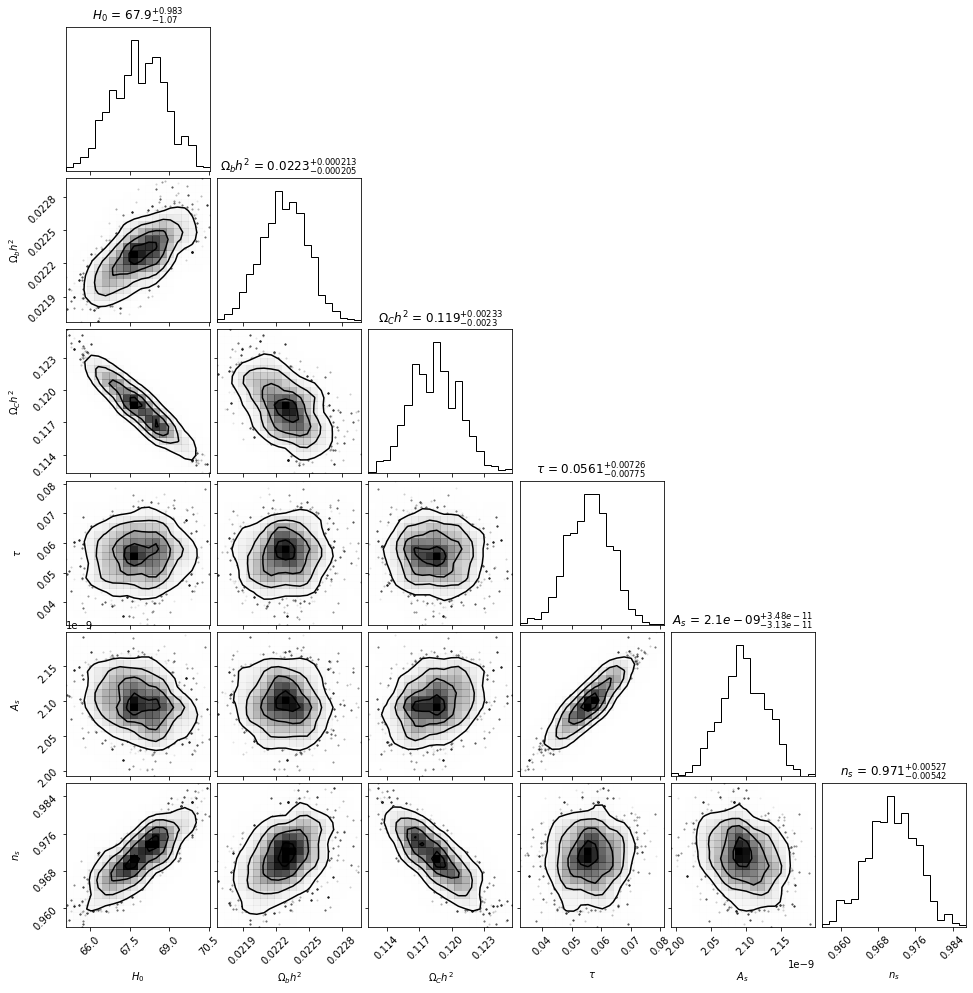

In [395]:
#needed quite a bit of burn in here
figure = corner.corner(chain_tau[600:], labels=[r'$H_0$',r'$\Omega_bh^2$',r'$\Omega_Ch^2$',r'$\tau$',r'$A_s$',r'$n_s$'],
                       smooth=True,title_fmt = '.3g',
                       show_titles=True, title_kwargs={"fontsize": 12})

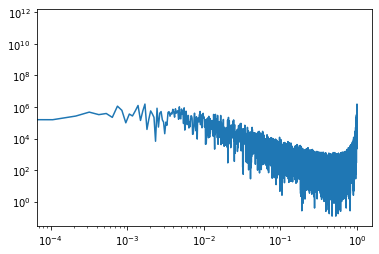

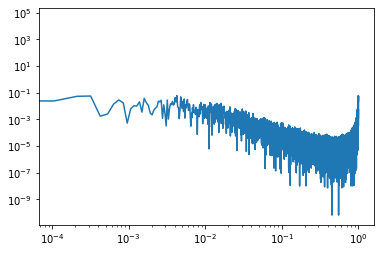

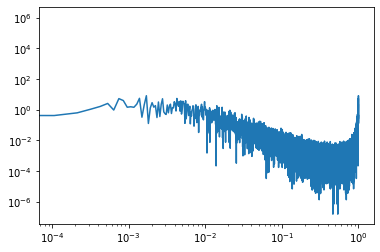

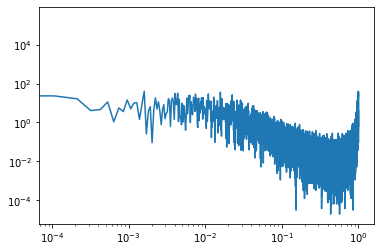

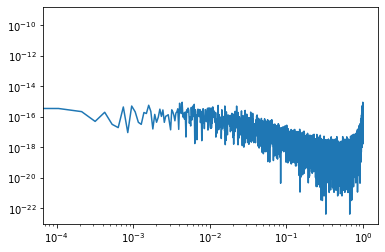

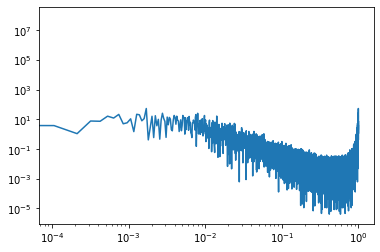

In [396]:
for i in range(len(chain.T)):
    plt.loglog(np.linspace(0,1,len(chain_tau[600:].T[i])),np.abs(np.fft.fft(chain_tau[600:].T[i]))**2) 
    plt.show()